In [17]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

from data.make_dataset import ImageDataset
from models import UNet, AttentionUNet, TransformerUNet
from utils.Metrics import Metrics
from utils.losses import DiceBCELoss
from utils.plot import plot_losses, plot_generic
from utils.config import DTYPE, get_device
from utils.config import ACCURACY, AUPRC, AUROC_, DICE_SCORE, F1_SCORE, JACCARD_INDEX, PRECISION, RECALL, SPECIFICITY

from train import train
from evaluate import evaluate

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = get_device()
device

device(type='cuda')

In [3]:
train_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/TRAIN", "../data/raw/Br35H-Mask-RCNN/TRAIN_MASK")
val_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/VAL", "../data/raw/Br35H-Mask-RCNN/VAL_MASK")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
import torch.nn as nn
def init_weights(model: nn.Module):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.1)

In [42]:
train_metrics = Metrics(device, 2)
val_metrics = Metrics(device, 2)
epochs = 20

train_loss_batch = []
train_loss = []
val_loss = []

model = AttentionUNet((1, 32, 64, 128, 256, 512, 1024), False, True).to(device)
init_weights(model)
criterion = DiceBCELoss(device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.15, patience=2)

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    train_metrics.reset()
    val_metrics.reset()
    t1, t2 = train(model, criterion, optimizer, device, train_loader, train_metrics)
    train_loss_batch.extend(t1)
    train_loss.append(t2)
    val_loss.append(evaluate(model, criterion, device, val_loader, val_metrics))
    scheduler.step(val_loss[-1])
    train_agg_metrics = train_metrics.compute()
    val_agg_metrics = val_metrics.compute()

    print(f'Training   - Accuracy: {train_agg_metrics[ACCURACY]:.4f} | Dice: {train_agg_metrics[DICE_SCORE]:.4f} | IoU: {train_agg_metrics[JACCARD_INDEX]:.4f} | Loss: {t2:.4f}')
    print(f'Validation - Accuracy: {val_agg_metrics[ACCURACY]:.4f} | Dice: {val_agg_metrics[DICE_SCORE]:.4f} | IoU: {val_agg_metrics[JACCARD_INDEX]:.4f} | Loss: {val_loss[-1]:.4f}')
    print()

Epoch 1/20


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.16it/s, Accuracy=0.9550, Dice=0.3989, IoU=0.6017, Loss=1.0396]

Training   - Accuracy: 0.9256 | Dice: 0.4128 | IoU: 0.5919 | Loss: 1.0392
Validation - Accuracy: 0.9372 | Dice: 0.4489 | IoU: 0.6125 | Loss: 1.0409

Epoch 2/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.72it/s, Accuracy=0.9586, Dice=0.0988, IoU=0.5052, Loss=0.8914]

Training   - Accuracy: 0.9587 | Dice: 0.5053 | IoU: 0.6480 | Loss: 0.7245
Validation - Accuracy: 0.9580 | Dice: 0.2936 | IoU: 0.5648 | Loss: 0.8700

Epoch 3/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.78it/s, Accuracy=0.7479, Dice=0.2145, IoU=0.4295, Loss=1.8005]

Training   - Accuracy: 0.9632 | Dice: 0.5381 | IoU: 0.6652 | Loss: 0.6108
Validation - Accuracy: 0.7024 | Dice: 0.2297 | IoU: 0.4091 | Loss: 1.8237

Epoch 4/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s, Accuracy=0.9584, Dice=0.4375, IoU=0.6188, Loss=0.5214]

Training   - Accuracy: 0.9655 | Dice: 0.5805 | IoU: 0.6868 | Loss: 0.5390
Validation - Accuracy: 0.9699 | Dice: 0.6539 | IoU: 0.7274 | Loss: 0.4967

Epoch 5/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.95it/s, Accuracy=0.9585, Dice=0.4536, IoU=0.6255, Loss=0.4972]

Training   - Accuracy: 0.9689 | Dice: 0.6244 | IoU: 0.7110 | Loss: 0.4708
Validation - Accuracy: 0.9682 | Dice: 0.6886 | IoU: 0.7461 | Loss: 0.4733

Epoch 6/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s, Accuracy=0.9623, Dice=0.4182, IoU=0.6131, Loss=0.4764]

Training   - Accuracy: 0.9700 | Dice: 0.6594 | IoU: 0.7305 | Loss: 0.4322
Validation - Accuracy: 0.9698 | Dice: 0.6209 | IoU: 0.7096 | Loss: 0.4567

Epoch 7/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.36it/s, Accuracy=0.9725, Dice=0.5639, IoU=0.6823, Loss=0.3938]

Training   - Accuracy: 0.9747 | Dice: 0.7202 | IoU: 0.7683 | Loss: 0.3538
Validation - Accuracy: 0.9732 | Dice: 0.7165 | IoU: 0.7652 | Loss: 0.3871

Epoch 8/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s, Accuracy=0.9736, Dice=0.6288, IoU=0.7158, Loss=0.4920]

Training   - Accuracy: 0.9796 | Dice: 0.7903 | IoU: 0.8160 | Loss: 0.2872
Validation - Accuracy: 0.9681 | Dice: 0.5894 | IoU: 0.6926 | Loss: 0.4955

Epoch 9/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s, Accuracy=0.9676, Dice=0.4329, IoU=0.6217, Loss=0.7486]

Training   - Accuracy: 0.9779 | Dice: 0.7668 | IoU: 0.7995 | Loss: 0.3024
Validation - Accuracy: 0.9594 | Dice: 0.2901 | IoU: 0.5644 | Loss: 0.7642

Epoch 10/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s, Accuracy=0.9717, Dice=0.6967, IoU=0.7527, Loss=0.3486]

Training   - Accuracy: 0.9803 | Dice: 0.7972 | IoU: 0.8212 | Loss: 0.2673
Validation - Accuracy: 0.9753 | Dice: 0.7659 | IoU: 0.7974 | Loss: 0.3377

Epoch 11/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s, Accuracy=0.9808, Dice=0.7414, IoU=0.7847, Loss=0.3076]

Training   - Accuracy: 0.9826 | Dice: 0.8244 | IoU: 0.8416 | Loss: 0.2329
Validation - Accuracy: 0.9776 | Dice: 0.7554 | IoU: 0.7919 | Loss: 0.3090

Epoch 12/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.87it/s, Accuracy=0.9783, Dice=0.7155, IoU=0.7673, Loss=0.2796]

Training   - Accuracy: 0.9830 | Dice: 0.8270 | IoU: 0.8437 | Loss: 0.2254
Validation - Accuracy: 0.9803 | Dice: 0.7868 | IoU: 0.8141 | Loss: 0.2706

Epoch 13/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.97it/s, Accuracy=0.9776, Dice=0.6938, IoU=0.7541, Loss=0.2894]

Training   - Accuracy: 0.9848 | Dice: 0.8473 | IoU: 0.8596 | Loss: 0.2002
Validation - Accuracy: 0.9789 | Dice: 0.7598 | IoU: 0.7954 | Loss: 0.2814

Epoch 14/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s, Accuracy=0.9818, Dice=0.7468, IoU=0.7886, Loss=0.3024]

Training   - Accuracy: 0.9855 | Dice: 0.8578 | IoU: 0.8679 | Loss: 0.1934
Validation - Accuracy: 0.9783 | Dice: 0.7503 | IoU: 0.7890 | Loss: 0.3040

Epoch 15/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.87it/s, Accuracy=0.9804, Dice=0.7214, IoU=0.7721, Loss=0.3242]

Training   - Accuracy: 0.9862 | Dice: 0.8600 | IoU: 0.8699 | Loss: 0.1808
Validation - Accuracy: 0.9761 | Dice: 0.7126 | IoU: 0.7645 | Loss: 0.3244

Epoch 16/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s, Accuracy=0.9821, Dice=0.7607, IoU=0.7977, Loss=0.2492]

Training   - Accuracy: 0.9888 | Dice: 0.8896 | IoU: 0.8947 | Loss: 0.1489
Validation - Accuracy: 0.9818 | Dice: 0.8038 | IoU: 0.8265 | Loss: 0.2457

Epoch 17/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s, Accuracy=0.9834, Dice=0.7678, IoU=0.8030, Loss=0.2766]

Training   - Accuracy: 0.9896 | Dice: 0.8967 | IoU: 0.9009 | Loss: 0.1405
Validation - Accuracy: 0.9799 | Dice: 0.7705 | IoU: 0.8029 | Loss: 0.2772

Epoch 18/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.78it/s, Accuracy=0.9828, Dice=0.7704, IoU=0.8044, Loss=0.2554]

Training   - Accuracy: 0.9900 | Dice: 0.9019 | IoU: 0.9054 | Loss: 0.1353
Validation - Accuracy: 0.9815 | Dice: 0.8004 | IoU: 0.8240 | Loss: 0.2539

Epoch 19/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.69it/s, Accuracy=0.9831, Dice=0.7615, IoU=0.7987, Loss=0.2832]

Training   - Accuracy: 0.9903 | Dice: 0.9040 | IoU: 0.9074 | Loss: 0.1288
Validation - Accuracy: 0.9795 | Dice: 0.7629 | IoU: 0.7978 | Loss: 0.2833

Epoch 20/20



Validation: 100%|██████████| 7/7 [00:00<00:00,  9.81it/s, Accuracy=0.9834, Dice=0.7780, IoU=0.8097, Loss=0.2588]

Training   - Accuracy: 0.9905 | Dice: 0.9060 | IoU: 0.9091 | Loss: 0.1268
Validation - Accuracy: 0.9813 | Dice: 0.7937 | IoU: 0.8193 | Loss: 0.2578



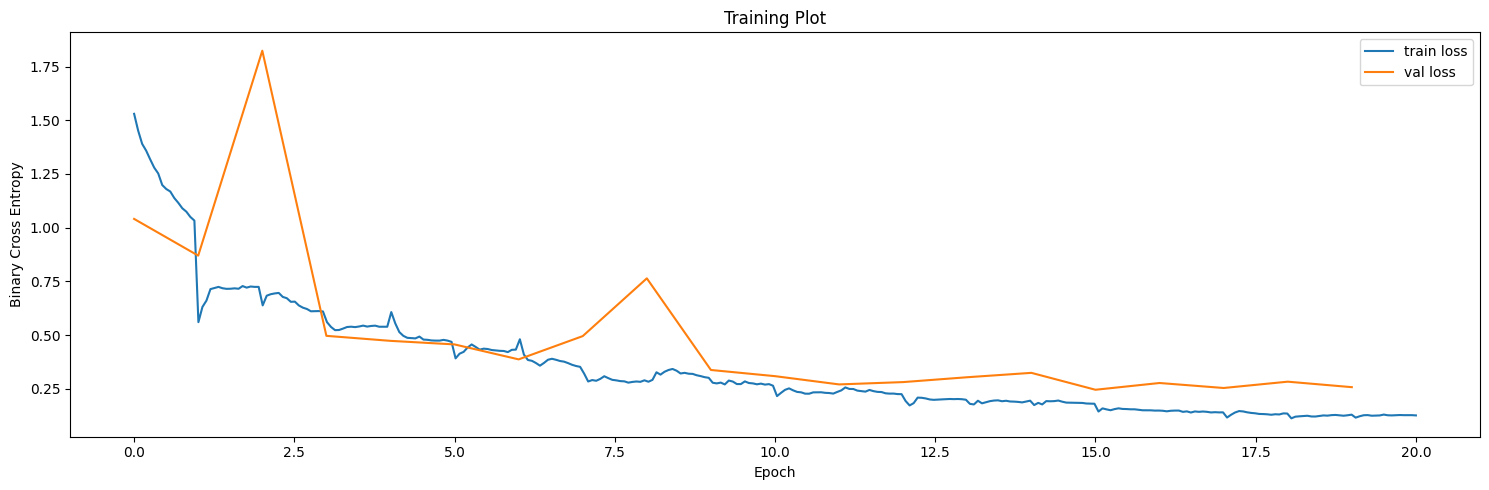

In [43]:
plot_losses(train_loss_batch, val_loss)

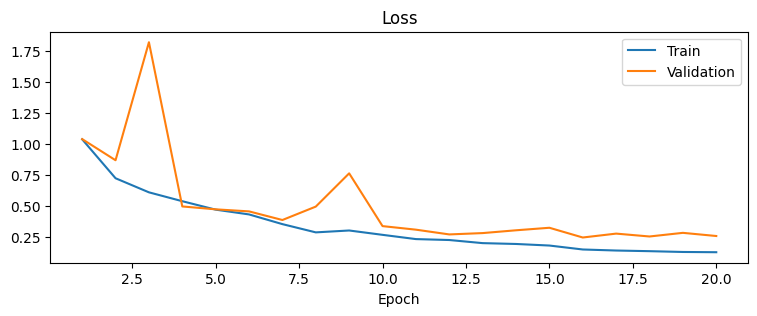

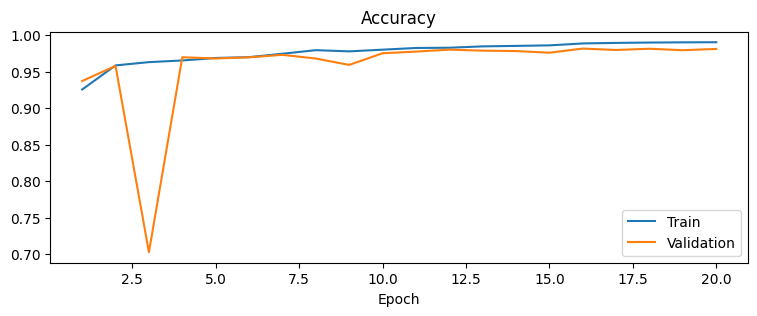

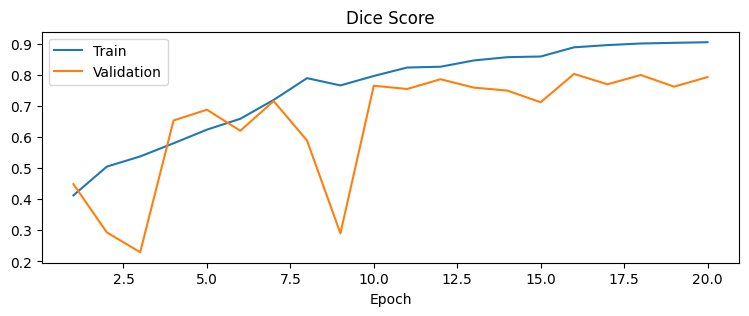

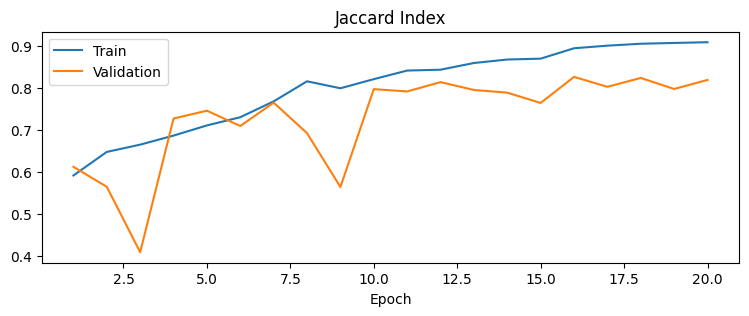

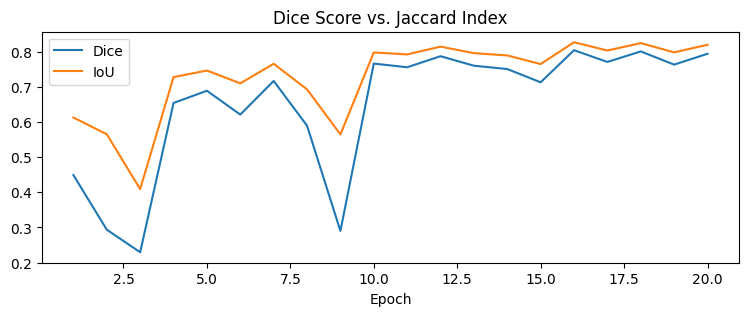

In [47]:
train_metrics_acc = train_metrics.get_metrics()
val_metrics_acc = val_metrics.get_metrics()
plot_generic('Loss', 'Epoch', 'Train', train_loss, 'Validation', val_loss)
plot_generic('Accuracy', 'Epoch', 'Train', train_metrics_acc[ACCURACY], 'Validation', val_metrics_acc[ACCURACY])
plot_generic('Dice Score', 'Epoch', 'Train', train_metrics_acc[DICE_SCORE], 'Validation', val_metrics_acc[DICE_SCORE])
plot_generic('Jaccard Index', 'Epoch', 'Train', train_metrics_acc[JACCARD_INDEX], 'Validation', val_metrics_acc[JACCARD_INDEX])
plot_generic('Dice Score vs. Jaccard Index', 'Epoch', 'Dice', val_metrics_acc[DICE_SCORE], 'IoU', val_metrics_acc[JACCARD_INDEX])